In [91]:
import h5py
import json
import math
from math import floor
from PIL import Image, ImageDraw
import random

import torch
import numpy as np

In [92]:
!ls

0.generate_attribute_labels.ipynb  original_data
1.bbox_check.ipynb		   resized1024_data
1024image_data.json		   testing
VG-SGG-dicts-with-attri-1024.json  updated1024VG-SGG-dicts.json
ata_data			   updated1024VG-SGG.h5
ata_data2			   updated1024objects.json
attribute_synsets.json		   updated1024objects_attributes.json
generate_attribute_labels.py	   updatedResized1024_data
kim_data_2592			   updatedVG-SGG-with-attri-1024_2.h5


In [93]:
# generated SGG labels
image_data = json.load(open('1024image_data.json'))
vg_sgg_dicts = json.load(open('updated1024VG-SGG-dicts.json'))
vg_sgg = h5py.File('updatedVG-SGG-with-attri-1024_2.h5', 'r')

# download from https://visualgenome.org
# objects.json from https://visualgenome.org/static/data/dataset/objects_v1_2.json.zip
# attributes.json from https://visualgenome.org/static/data/dataset/attributes.json.zip
# attribute_synsets.json from https://visualgenome.org/static/data/dataset/attribute_synsets.json.zip
original_objects = json.load(open("updated1024objects.json"))
original_attributes = json.load(open("updated1024objects_attributes.json"))
original_attribute_synsets = json.load(open("attribute_synsets.json"))

In [94]:
"""
NOTE:Counting the number of atttributes for each objects
we should use a threshold to select the maximum number of attributes 
for each objects for efficiency
"""
def count_num_attri_per_obj(all_attributes, MAX_NUM_ATT=20):
    num_attr_count = [0]*MAX_NUM_ATT
    for img in all_attributes:
        img_annos = img['attributes']
        for anno in img_annos:
            if 'attributes' in anno:
                len_attr = len(anno['attributes'])
                if len_attr >= MAX_NUM_ATT-1:
                    num_attr_count[MAX_NUM_ATT-1] += 1
                else:
                    num_attr_count[len_attr] += 1
            else:
                num_attr_count[0] += 1

    return num_attr_count

In [95]:
"""
NOTE: calculate the number of objects for each image
"""
def count_num_obj_per_img(original_objects, MAX_NUM_OBJ=50, print_multi_label=False):
    num_obj_count = [0]*MAX_NUM_OBJ
    for img in original_objects:
        img_annos = img['objects']
        len_obj = len(img_annos)
        if len_obj >= MAX_NUM_OBJ-1:
            num_obj_count[MAX_NUM_OBJ-1] += 1
        else:
            num_obj_count[len_obj] += 1
        for anno in img_annos:
            if len(anno['names']) != 1 and print_multi_label:
                print('obj_id: {} with {}'.format(anno['object_id'], anno['names']))
   
    return num_obj_count

In [96]:
"""
NOTE: Counting the number of each attribute categories
it can be used to select the most frequent attributes in the dataset
we should also use the attribute_synsets to merge the similar categories
Return a dictionary
"""
def count_attributes(all_attributes):
    attribute_counts = {}
    for img in all_attributes:
        img_annos = img['attributes']
        for anno in img_annos:
            if 'attributes' in anno:
                for item in anno['attributes']:
                    item = ' '.join(item.lower().split())
                    if item in attribute_counts:
                        attribute_counts[item] = attribute_counts[item] + 1
                    else:
                        attribute_counts[item] = 1

    return attribute_counts

In [97]:
def attribute_to_index(attri_name, attri_to_idx, cared_mapping):
    original_name = attri_name
    attri_name = ' '.join(attri_name.lower().split())
    if attri_name in cared_mapping:
        attri_name = cared_mapping[attri_name]
    #if original_name != attri_name:
        #print('CHANGE {} --> {}'.format(original_name, attri_name))
    if attri_name in attri_to_idx:
        return attri_to_idx[attri_name]
    else:
        return 0

In [98]:
"""
NOTE:Counting the number of atttributes for each objects
we should use a threshold to select the maximum number of attributes 
for each objects for efficiency
"""
def count_num_selected_attri_per_obj(all_attributes, attribute_to_idx, cared_mapping, MAX_NUM_ATT=20):
    num_attr_count = [0]*MAX_NUM_ATT
    for img in all_attributes:
        img_annos = img['attributes']
        for anno in img_annos:
            if 'attributes' in anno:
                selected_attries = []
                for att_name in anno['attributes']:
                    idx = attribute_to_index(att_name, attribute_to_idx, cared_mapping)
                    if idx != 0:
                        selected_attries.append(idx)
                selected_attries = list(set(selected_attries))
                len_attr = len(selected_attries)
                if len_attr >= MAX_NUM_ATT-1:
                    num_attr_count[MAX_NUM_ATT-1] += 1
                else:
                    num_attr_count[len_attr] += 1
            else:
                num_attr_count[0] += 1
    return num_attr_count

In [99]:
"""
NOTE: process attribute_synsets
"""
def processing_attribute_synsets(attribute_synsets, attributes_count):
    attribute_mapping = {}
    type_counting = {}
    num_counting = {}
    for key, val in attribute_synsets.items():
        val_split = val.split('.')
        if len(val_split) != 3:
            print('--------------------------------')
            print('old_val: ', key, val)
            val = '_'.join(val_split[:-2]) + '.' + val_split[-2] + '.' + val_split[-1]
            print('new_val: ', key, val)
            print('--------------------------------')
        key_root, key_type, key_num = val.split('.')
        if key in attributes_count:
            key_count = attributes_count[key]
        else:
            key_count = 0
        attribute_mapping[key] = {'key_root' : key_root, 'key_type' : key_type, 'key_num' : key_num, 'key_count' : key_count}
        if key_type in type_counting:
            type_counting[key_type] = type_counting[key_type] + 1
        else:
            type_counting[key_type] = 1
        if key_num in num_counting:
            num_counting[key_num] = num_counting[key_num] + 1
        else:
            num_counting[key_num] = 1
    return attribute_mapping, type_counting, num_counting

In [100]:
"""
Merge synset attribute based on attribute_synsets
NOTE that, the attribute is not clean, especially those infrequent attribute
so we do the following steps
Step 1: select most frequent attribute (because they tend to be more clean and general)
Step 2: only merge those key_root synset pair both occoured in select frequency list
Step 2 Explain: when key not in list but root in, these keys can be very noise, so we skip them
Step 3: padding new attributes to reach TOPK based on the number of merged synsets

So what we want to make sure is, there is no synsets in selected attributes
"""
def merge_synset_attribute(mapping_dict, attribute_counts_list, TOPK=14): #TOPK is 
    selected_attributes = attribute_counts_list[:TOPK]
    selected_attributes = [item[0] for item in selected_attributes]
    
    cared_mapping = {}
    for key, info in mapping_dict.items():
        if (key in selected_attributes) and (info['key_root'] in selected_attributes) and (key != info['key_root']):
            cared_mapping[key] = info['key_root']
        elif (key in selected_attributes) and (info['key_root'] not in selected_attributes):
            # key in, root not
            continue
        elif (key not in selected_attributes) and (info['key_root'] in selected_attributes):
            # IMPORTANT!
            # It't not clean, too dirty
            # we don't merge these key
            continue
            #key_not_root_in[key] = info['key_root']
        elif (key not in selected_attributes) and (info['key_root'] not in selected_attributes):
            # both not in
            continue
        else:
            # key == root, and in dict
            continue
    # eventually selected attributes
    purged_attributes = attribute_counts_list[:TOPK+len(cared_mapping)]
    purged_attributes = [item[0] for item in purged_attributes]
    for removed_key in list(cared_mapping.keys()):
        purged_attributes.remove(removed_key)
    # in case we missing some
    assert len(purged_attributes) == TOPK
    selected_attributes = purged_attributes + list(cared_mapping.keys())
    return cared_mapping, purged_attributes, selected_attributes

In [101]:
"""
add attribute_count, idx_to_attribute, attribute_to_idx
to vg_sgg_dicts
"""
def add_attribute_to_json(purged_atts, vg_sgg_dicts, cared_mapping, all_attribute_counts):
    # construct attribute_count
    attribute_count = {}
    for att in purged_atts:
        attribute_count[att] = all_attribute_counts[att]
    for key, val in cared_mapping.items():
        attribute_count[val] = all_attribute_counts[val] + all_attribute_counts[key]
    vg_sgg_dicts['attribute_count'] = attribute_count
    
    # construct idx_to_attribute and attribute_to_idx
    idx_to_attribute = {}
    attribute_to_idx = {}
    for i, att in enumerate(purged_atts):
        idx_to_attribute[str(i+1)] = att
        attribute_to_idx[att] = i+1
    vg_sgg_dicts['idx_to_attribute'] = idx_to_attribute
    vg_sgg_dicts['attribute_to_idx'] = attribute_to_idx
    return vg_sgg_dicts

In [102]:
def get_image_info(image_data, all_attributes):
    image_info = []
    attri_info = []
    corrupted_ims = ['1592', '1722', '4616', '4617']
    for item, att_item in zip(image_data, all_attributes):
        if str(item['image_id']) not in corrupted_ims:
            assert item['image_id'] == att_item['image_id']
            image_info.append(item)
            attri_info.append(att_item['attributes'])
    return image_info, attri_info

In [103]:
def encode_box(region, org_h, org_w, im_long_size):
    x = region['x']
    y = region['y']
    w = region['w']
    h = region['h']
    scale = float(im_long_size) / max(org_h, org_w)
    image_size = im_long_size
    # recall: x,y are 1-indexed
    x, y = math.floor(scale*(region['x']-1)), math.floor(scale*(region['y']-1))
    w, h = math.ceil(scale*region['w']), math.ceil(scale*region['h'])

    # clamp to image
    if x < 0: x = 0
    if y < 0: y = 0

    # box should be at least 2 by 2
    if x > image_size - 2:
        x = image_size - 2
    if y > image_size - 2:
        y = image_size - 2
    if x + w >= image_size:
        w = image_size - x
    if y + h >= image_size:
        h = image_size - y

    # also convert to center-coord oriented
    box = np.asarray([x+floor(w/2), y+floor(h/2), w, h], dtype=np.int32)
    assert box[2] > 0  # width height should be positive numbers
    assert box[3] > 0
    return box

In [104]:
def bbox_iou(boxes1, boxes2, to_move=1):
    """
    boxes1 : numpy, [num_obj, 4] (x1,y1,x2,y2)
    boxes2 : numpy, [num_obj, 4] (x1,y1,x2,y2)
    """
    #print('boxes1: ', boxes1.shape)
    #print('boxes2: ', boxes2.shape)
    num_box1 = boxes1.shape[0]
    num_box2 = boxes2.shape[0]
    lt = np.maximum(boxes1.reshape([num_box1, 1, -1])[:,:,:2], boxes2.reshape([1, num_box2, -1])[:,:,:2]) # [N,M,2]
    rb = np.minimum(boxes1.reshape([num_box1, 1, -1])[:,:,2:], boxes2.reshape([1, num_box2, -1])[:,:,2:]) # [N,M,2]

    wh = (rb - lt + to_move).clip(min=0)  # [N,M,2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

    lb = np.minimum(boxes1.reshape([num_box1, 1, -1])[:,:,:2], boxes2.reshape([1, num_box2, -1])[:,:,:2]) # [N,M,2]
    rt = np.maximum(boxes1.reshape([num_box1, 1, -1])[:,:,2:], boxes2.reshape([1, num_box2, -1])[:,:,2:]) # [N,M,2]
    wh = (rt - lb + to_move).clip(min=0)
    outer = wh[:, :, 0] * wh[:, :, 1] + 1e-9  # [N,M]
    return inter/outer

In [105]:
def create_new_vg_sgg_h5py(vg_sgg, attributes, name='VG-SGG-with-attri.h5'):
    vg_sgg_with_attri = h5py.File(name, 'w')
    # copy from original vg_sgg
    for key in list(vg_sgg.keys()):
        vg_sgg_with_attri.create_dataset(key, data=vg_sgg[key][:])
    # add attributes
    vg_sgg_with_attri.create_dataset('attributes', data=attributes)
    vg_sgg_with_attri.close()

In [106]:
# MAIN 
"""
various counting methods
"""
num_attr_count = count_num_attri_per_obj(original_attributes, 20)
num_obj_count = count_num_obj_per_img(original_objects, MAX_NUM_OBJ=300)
attribute_counts = count_attributes(original_attributes)


"""
select most frequent attribute by threshold
"""
# get sorted attribute list
attribute_counts_list = [(key, val) for key, val in attribute_counts.items()]
attribute_counts_list.sort(key=lambda v:v[1], reverse=True)
# merge synset words
mapping_dict, type_count, num_count = processing_attribute_synsets(original_attribute_synsets, attribute_counts)
cared_mapping, purged_atts, selected_atts = merge_synset_attribute(mapping_dict, attribute_counts_list, TOPK=14)
vg_sgg_dicts = add_attribute_to_json(purged_atts, vg_sgg_dicts, cared_mapping, attribute_counts)
# save vg_sgg_dicts_with_attri.json
with open('VG-SGG-dicts-with-attri-1024.json', 'w') as outfile:  
    json.dump(vg_sgg_dicts, outfile)

vg_sgg_dicts = json.load(open('VG-SGG-dicts-with-attri-1024.json'))
idx_to_attribute = vg_sgg_dicts['idx_to_attribute']
attribute_to_idx = vg_sgg_dicts['attribute_to_idx']

"""
assign attributes to each bounding box
"""
image_info, attri_info = get_image_info(image_data, original_attributes)

In [107]:
"""
assign attribute annotation to each objects
"""
USE_BOX_SIZE = 1024

def get_xyxy_boxes(img_atts, img_info):
    box_list = []
    for item in img_atts:
        box_list.append(encode_box(item, img_info['height'], img_info['width'], USE_BOX_SIZE))
    box_list = np.vstack(box_list)
    box_list[:, :2] = box_list[:, :2] - box_list[:, 2:] / 2
    box_list[:, 2:] = box_list[:, :2] + box_list[:, 2:]
    return box_list
    
def create_attributes_per_obj(vg_sgg, attri_info, image_info, attri_to_idx, cared_mapping, MAX_NUM_ATT=10, iou_thres=0.85):
    num_objs = vg_sgg['labels'].shape[0]
    num_imgs = vg_sgg['split'].shape[0]
    assert num_imgs == len(attri_info)
    assert num_imgs == len(image_info)
    obj_attributes = np.zeros((num_objs, MAX_NUM_ATT)).astype(np.int64)
    
    num_matched_box = 0
    for img_idx in range(num_imgs):
        ith_s = vg_sgg['img_to_first_box'][img_idx]
        ith_e = vg_sgg['img_to_last_box'][img_idx]
        img_atts = attri_info[img_idx]
        img_info = image_info[img_idx]
        if len(img_atts) == 0:
            #print('Image ID: {} has no ground truth objects.'.format(img_idx))
            continue
        img_boxes = get_xyxy_boxes(img_atts, img_info)
        for obj_idx in range(ith_s, ith_e+1):
            obj_att_set = []
            obj_box = vg_sgg['boxes_1024'][obj_idx].reshape(1, -1)
            obj_box[:, :2] = obj_box[:, :2] - obj_box[:, 2:] / 2
            obj_box[:, 2:] = obj_box[:, :2] + obj_box[:, 2:]
            match_idxs = (bbox_iou(img_boxes, obj_box) > iou_thres).astype(np.int64).reshape(-1)
            if float(match_idxs.sum()) > 0:
                num_matched_box += 1
            for match_idx in np.where(match_idxs)[0].tolist():
                if 'attributes' in img_atts[match_idx]:
                    for attri_name in img_atts[match_idx]['attributes']:
                        att_idx = attribute_to_index(attri_name, attri_to_idx, cared_mapping)
                        if att_idx != 0:
                            obj_att_set.append(att_idx)
            # remove duplicate
            obj_att_set = list(set(obj_att_set))[:MAX_NUM_ATT]
            for i, att_idx in enumerate(obj_att_set):
                obj_attributes[obj_idx, i] = att_idx
    return obj_attributes, num_matched_box
            

In [108]:
"""
generate attribute for each image
"""
obj_attributes, num_matched_box = create_attributes_per_obj(vg_sgg, attri_info, image_info, attribute_to_idx, cared_mapping, MAX_NUM_ATT=10, iou_thres=0.7)

In [111]:
"""
save to h5py
"""
create_new_vg_sgg_h5py(vg_sgg, obj_attributes, name='updatedVG-SGG-with-attri-1024_234.h5')

ValueError: Unable to create dataset (name already exists)

In [112]:
(obj_attributes.sum(-1) > 0).sum() / obj_attributes.shape[0]

1.0

In [113]:
num_matched_box / obj_attributes.shape[0]

1.0

In [114]:
(obj_attributes==14).sum()

14

In [116]:
"""
NOTE： visualize the generated attribute
"""

def draw_single_box(pic, box, color=(255,0,255,128)):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    
def draw_boxes(image_id, boxes):
    pic = Image.open('/home/kim/mini_cond_sgg_env/Scene-Graph-Benchmark/datasets/vg_resized_fiona/1024_images/{}.jpg'.format(image_id))
    
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        draw_single_box(pic, boxes[i])
    return pic
    
def show_box_attributes(image_data, vg_sgg, obj_attributes, vg_sgg_dicts, img_idx=None):
    idx_to_label = vg_sgg_dicts['idx_to_label']
    idx_to_attribute = vg_sgg_dicts['idx_to_attribute']
    if img_idx is None:
        img_idx = random.randint(0,len(image_data)-1)
    height, width = image_data[img_idx]['height'], image_data[img_idx]['width']
    filename = '/home/kim/mini_cond_sgg_env/Scene-Graph-Benchmark/datasets/vg_resized_fiona/1024_images/{}.jpg'.format(str(image_data[img_idx]['image_id']))
    pic = Image.open(filename)
    ith_s = vg_sgg['img_to_first_box'][img_idx]
    ith_e = vg_sgg['img_to_last_box'][img_idx]
    obj_idx = random.randint(ith_s, ith_e)
    box = vg_sgg['boxes_1024'][obj_idx]
    label = vg_sgg['labels'][obj_idx]
    attribute = obj_attributes[obj_idx]
    box[:2] = box[:2] - box[2:] / 2
    box[2:] = box[:2] + box[2:]
    box = box.astype(float) / USE_BOX_SIZE * max(height, width)
    draw_single_box(pic, box)
    att_list = []
    if attribute.sum() > 0:
        for i in attribute.tolist():
            if i>0:
                att_list.append(idx_to_attribute[str(i)])
        print('Index: {}, Path: {}'.format(img_idx, filename))
        print('Label: {}'.format(idx_to_label[str(int(label))]))
        print('Attribute: {}'.format(','.join(att_list)))
        return pic
    else:
        # make sure we have attributes
        return show_box_attributes(image_data, vg_sgg, obj_attributes, vg_sgg_dicts)
    

Index: 137, Path: /home/kim/mini_cond_sgg_env/Scene-Graph-Benchmark/datasets/vg_resized_fiona/1024_images/138.jpg
Label: door
Attribute: white,wooden


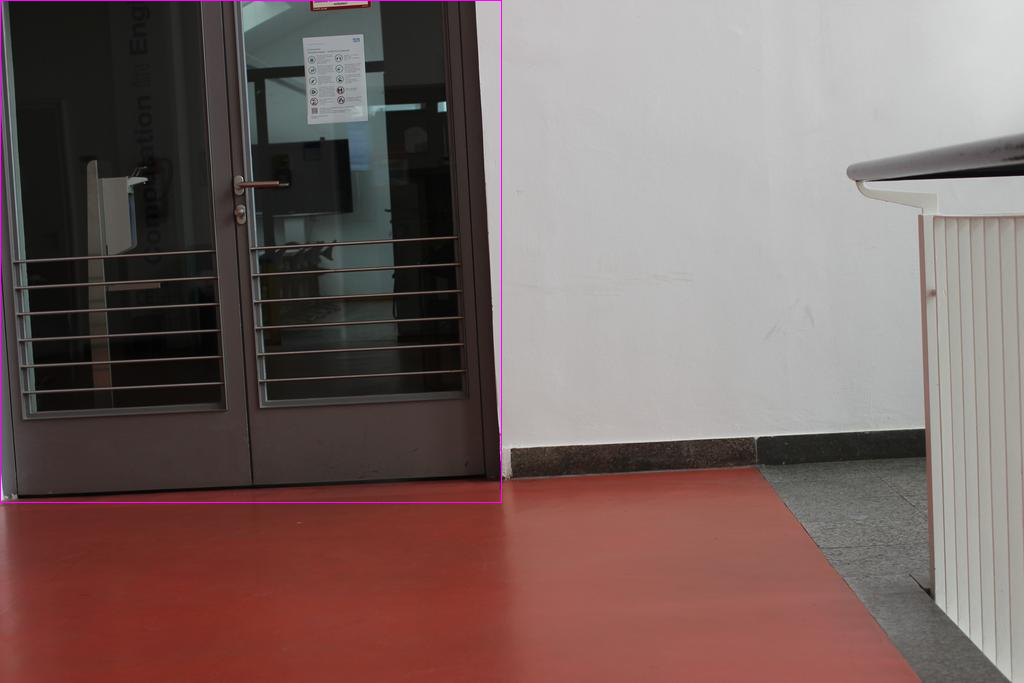

In [128]:
show_box_attributes(image_info, vg_sgg, obj_attributes, vg_sgg_dicts)

In [ ]:
"""
see all boxes of an image, if there is something wrong
"""
def show_wrong_image(wrong_idx, vg_sgg, image_info):
    ith_s = vg_sgg['img_to_first_box'][wrong_idx]
    ith_e = vg_sgg['img_to_last_box'][wrong_idx]

    wrong_boxes = vg_sgg['boxes_1024'][ith_s : ith_e+1]
    wrong_boxes[:, :2] = wrong_boxes[:, :2] - wrong_boxes[:, 2:] / 2
    wrong_boxes[:, 2:] = wrong_boxes[:, :2] + wrong_boxes[:, 2:]
    wrong_boxes = wrong_boxes.astype(float) / USE_BOX_SIZE * max(image_info[wrong_idx]['height'], image_info[wrong_idx]['width'])
    
    return draw_boxes(image_info[wrong_idx]['image_id'], wrong_boxes)

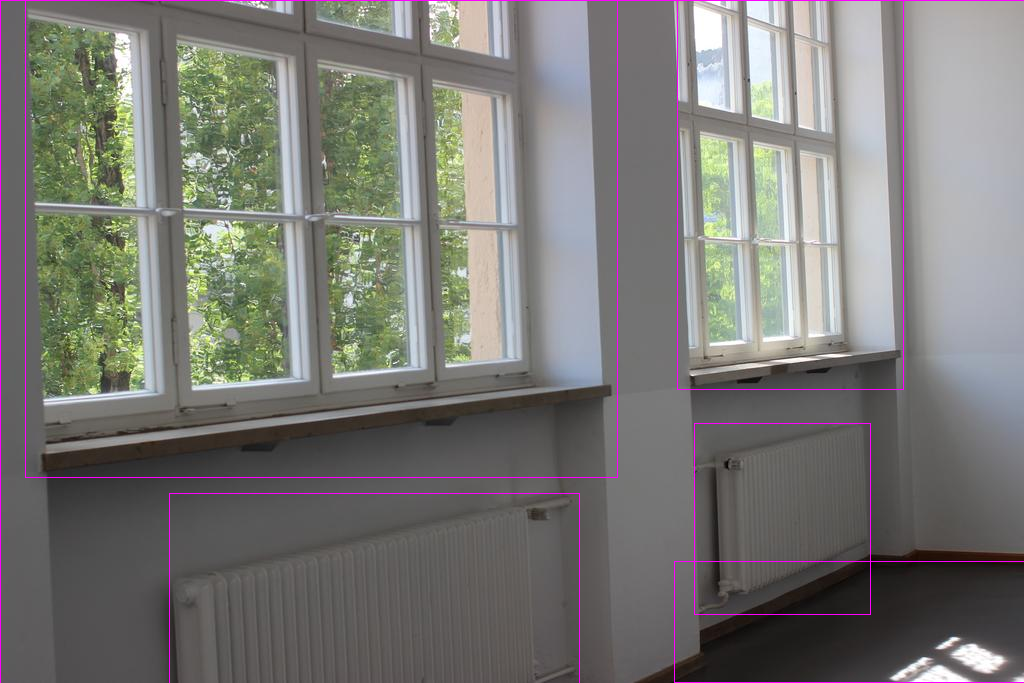

In [ ]:
show_wrong_image(85, vg_sgg, image_info)

In [ ]:
vg_sgg_dicts.keys()

dict_keys(['object_count', 'idx_to_label', 'predicate_to_idx', 'predicate_count', 'idx_to_predicate', 'label_to_idx', 'attribute_count', 'idx_to_attribute', 'attribute_to_idx'])

In [ ]:
vg_sgg_dicts['idx_to_predicate']

{'1': 'above',
 '2': 'attached to',
 '3': 'equipped with',
 '4': 'fixed on',
 '5': 'hanging from',
 '6': 'has opening in',
 '7': 'in front of',
 '8': 'joined with',
 '9': 'mounted on',
 '10': 'next to',
 '11': 'placed on',
 '12': 'under'}